# P2. Titanic: Machine Learning from Disaster

_The sinking of the Titanic is one of the most infamous shipwrecks in history._

_On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew._

_While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others._

_The goal of this project is to create a model capable of predicting which passengers survived the Titanic shipwreck_

Through analysis, we might be able to isolate certain variables that lead to higher survival rates, which may in turn be used in the future to structure ships in such a way as to minimise the loss of life in the event of a catastrophe.

## Initialising libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,
        font_scale = 1.5, color_codes=True)
from scipy.stats import randint
import math
import scipy

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.compose import ColumnTransformer 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis

In [2]:
titanic_raw = pd.read_csv("C:/Users/user/Documents/Q/datasets/titanic/train.csv", index_col="PassengerId", encoding="latin1")

In [3]:
titanic_raw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have replaced the `Id` column with the `PassengerId`.

- Our target variable is `Survived` where 0 = No and 1 = Yes. 
- The `pclass` column refers to the class of the passengers and ranges from 1 (Upper) - 3 (Lower) class. 
- Where `Age` is fractional, it is less than 1. 
- When `parch` = 0, the data refers to children travelling with a nanny
- `parch` and `sibsp` maybe be combineable depending on importance
- `Cabin` seems to have missing values but theoretically should be very important
- `Embarked` has three classes: S (Southampton), Q (Queenstown) and C (Cherbourg)
- `Name` attribute needs to be cleaned up, surnames and/or titles may be more important
- `Ticket` should be irrelevant, must investigate and clean if necessary
- `Fare`, `Class` and `Age` may be more important

In [4]:
titanic_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
titanic_raw.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

We have 80% of the data for `Age`, only 23% of the data for `Cabin` and `Embarked` has two missing values. All these missing values must be dealt with.

In [6]:
titanic_raw.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Bulk of the `fare` prices fall under $31. 
- Most people aged less than 40yo.

In [7]:
titanic_raw.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Attribute: Fare

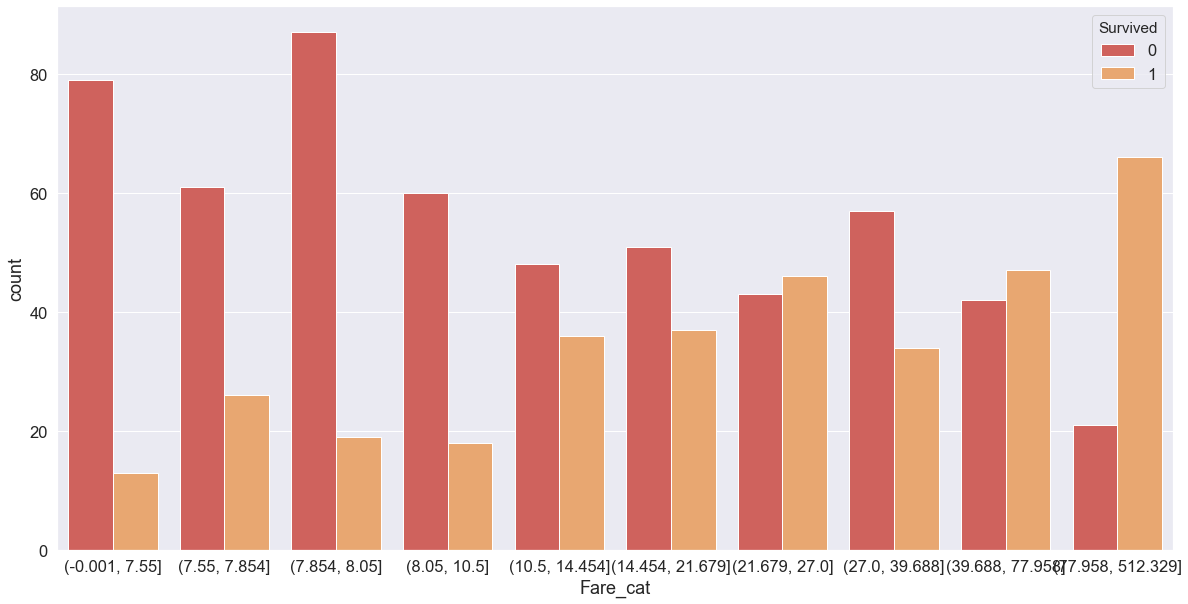

In [8]:
titanic_raw['Fare_cat'] = pd.qcut(titanic_raw['Fare'], 10, duplicates='drop')

plt.figure(figsize=(20, 10))

sns.countplot(x="Fare_cat", hue="Survived", data=titanic_raw)
plt.show()

### Attribute: Age

In [9]:
med = titanic_raw['Age'].median()

In [10]:
titanic_raw['Age'].fillna(titanic_raw['Age'].median(), inplace=True)

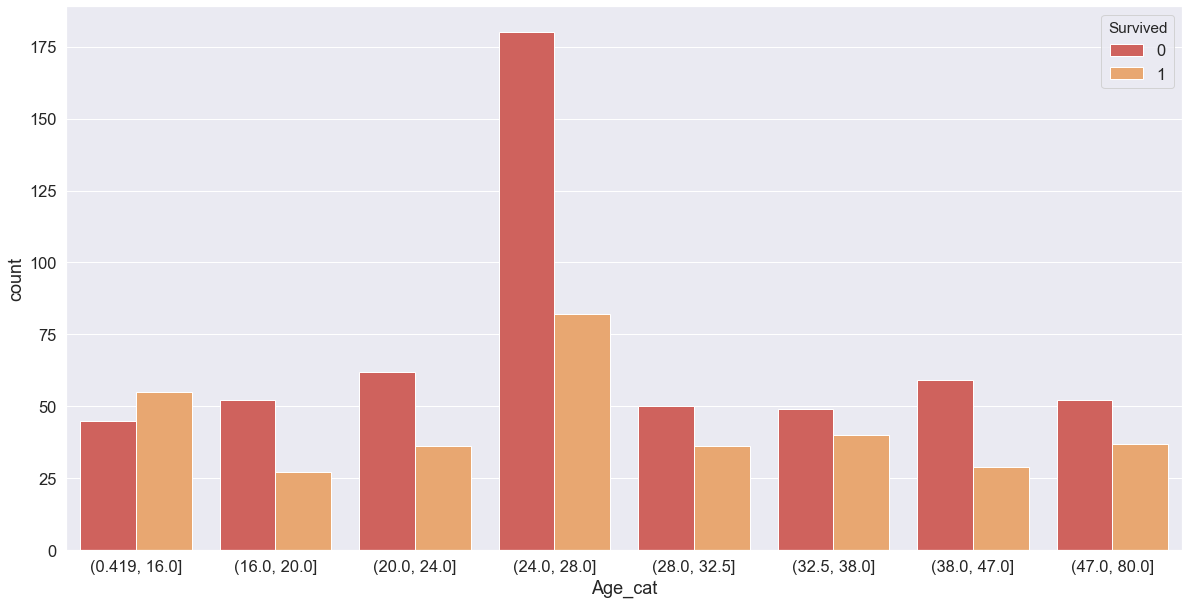

In [11]:
titanic_raw['Age_cat'] = pd.qcut(titanic_raw['Age'], 10, duplicates='drop')

plt.figure(figsize=(20, 10))

sns.countplot(x="Age_cat", hue="Survived", data=titanic_raw)
plt.show()

Here we see that survival rate is highest for the youngest children and then falls off until the age range of 31-36yo are considered. It is then lowest for the elderly.

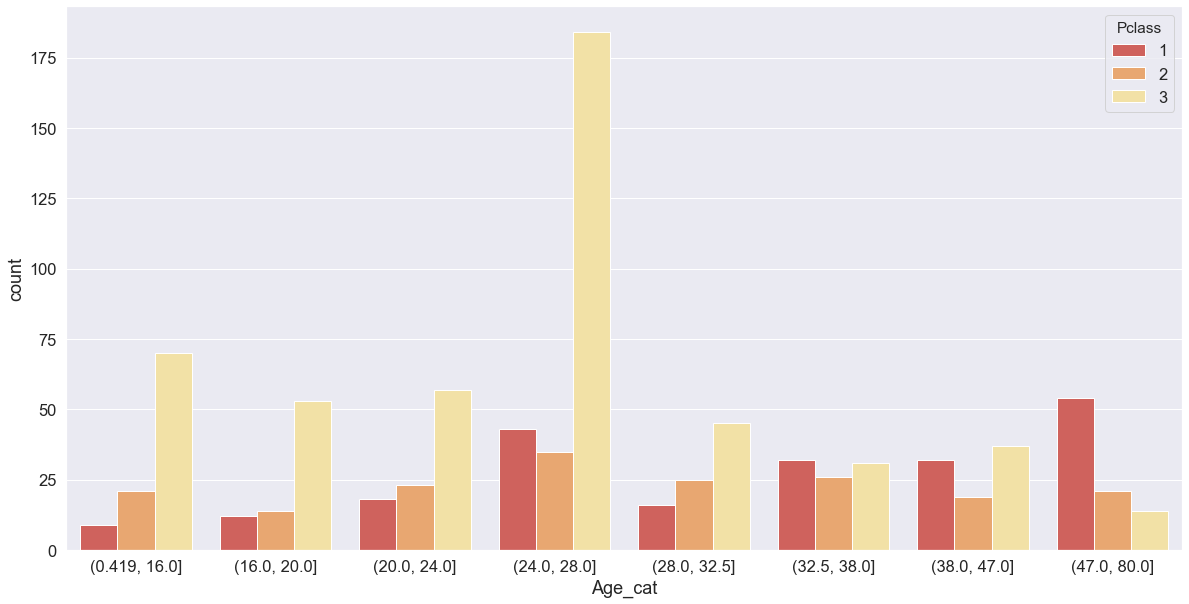

In [12]:
plt.figure(figsize=(20, 10))

sns.countplot(x="Age_cat", hue="Pclass", data=titanic_raw)
plt.show()

Since `Age` is the only attribute with missing values, we do not require the `Imputer` class to deal with the numerical attributes. 

We can discern a strong, inverted relationship between class and age here, as the younger passengers were primarly 3rd-class passengers and at the other end of the spectrum, those aged over 40 were the upper-class.

### Attribute: Sex

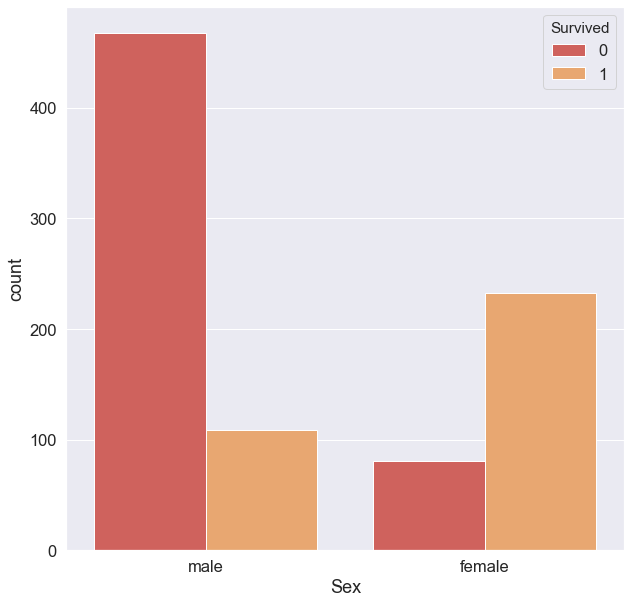

In [13]:
plt.figure(figsize=(10, 10))
sns.countplot(x="Sex", hue = "Survived", data=titanic_raw)
plt.show()

### Attribute: Cabin

To be able to study the relationships between `Cabin` and the other features, the values attributed to it must be changed such that only the preceeding letters remain as these likely denote the deck of the ship that the staterooms were allocated to.

In [14]:
cabins = []
cab_raw = titanic_raw["Cabin"]
for cabin in cab_raw:
    cabin = str(cabin)
    cab = cabin[0]
    cabins.append(cab)

In [15]:
titanic_raw['Cabin'] = cabins   
titanic_raw['Cabin'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

We have now seperated the values in `Cabin` into Decks ranging from A-G with an outlier in Deck T. Let's acquire more information about this passenger.

In [16]:
titanic_raw[titanic_raw['Cabin']=='T']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Age_cat
PassengerId,,,,,,,,,,,,,
340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,"(27.0, 39.688]","(38.0, 47.0]"


This paasenger was an upper-class individual, we need to investigate which other group he can be absorbed in, i.e which deck's population is he most similar to.

<Figure size 1440x1440 with 0 Axes>

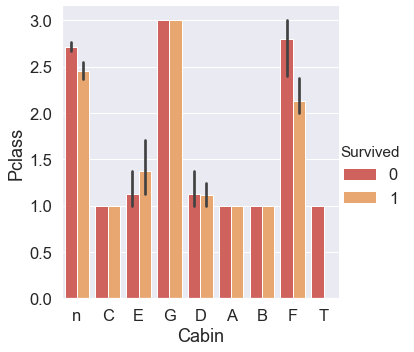

In [17]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Cabin", y="Pclass", hue = "Survived", kind="bar", data=titanic_raw)
plt.show()

We can infer from this plot that Decks A, B and C held the upper-class people, with lower classes being accomodated as a minority further down through Decks D-E and only the second and third-class people being housed on Decks F-G. `n` refers to missing values - the deck number is unknown for these passengers. Therefore, Mr Blackwell from Deck T is similar to passengers on Decks A-C. 

<Figure size 1440x1440 with 0 Axes>

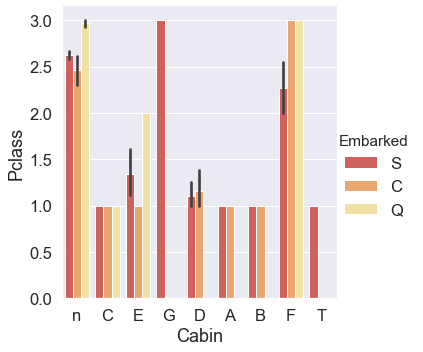

In [18]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Cabin", y="Pclass", hue = "Embarked", kind="bar", data=titanic_raw)
plt.show()

Deck C also contains passengers that embarked from Queenstown, whereas Blackwell embarked from Southampton, therefore it is safe to assume he is most similar to passengers from Decks A-B.

<Figure size 1440x1440 with 0 Axes>

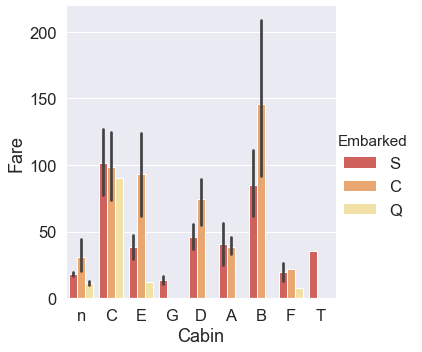

In [19]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Cabin", y="Fare", hue = "Embarked", kind="bar", data=titanic_raw)
plt.show()

From this final plot, we can confirm that Blackwell is most similar to passengers on Deck A, given the price he paid for his `Fare`.

In [20]:
titanic_raw["Cabin"].replace(to_replace="T", value='A', inplace=True)

To draw more accurate conclusions, we require the __survival rate__ for each cabin:

In [21]:
surv_perc = []

def survival_rate(cab):
    
    cabin = titanic_raw[titanic_raw['Cabin']==cab]
    survived = cabin[cabin['Survived'] == 1].shape[0]
    survival = survived / cabin.shape[0]
    survival = np.round(survival*100)
    print("The Survival Rate for Cabin {} was {}% among {} passengers".format(cab, survival, cabin.shape[0]))
    surv_perc.append(survival)
    
different_cabs = titanic_raw['Cabin'].unique()    

In [22]:
for cab in different_cabs:
    
    survival_rate(cab)

The Survival Rate for Cabin n was 30.0% among 687 passengers
The Survival Rate for Cabin C was 59.0% among 59 passengers
The Survival Rate for Cabin E was 75.0% among 32 passengers
The Survival Rate for Cabin G was 50.0% among 4 passengers
The Survival Rate for Cabin D was 76.0% among 33 passengers
The Survival Rate for Cabin A was 44.0% among 16 passengers
The Survival Rate for Cabin B was 74.0% among 47 passengers
The Survival Rate for Cabin F was 62.0% among 13 passengers


<Figure size 1440x1440 with 0 Axes>

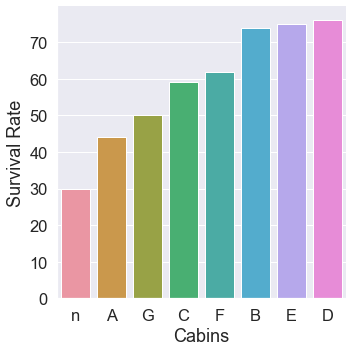

In [23]:
rate_df = pd.DataFrame(different_cabs, columns=['Cabins'])
rate_df['Survival Rate'] = surv_perc

plt.figure(figsize=(20, 20))
sns.catplot(x='Cabins', y='Survival Rate', kind="bar", data=rate_df, 
            order=rate_df.sort_values('Survival Rate').Cabins)
plt.show()

The survival rate of the inhabitants of Deck A is the lowest and Decks B, E and D have the highest survival rates. The lower rates for Decks A and C could also be a result of unfortunate positioning in the ship at the time of catastrophe. All in all, the `Cabin` feature is obviously very important as survival rates vary tremendously among the different decks, hence, we will retain this information in our training and test data.

### Attribute: Ticket

In [24]:
titanic_raw["Ticket"].value_counts

<bound method IndexOpsMixin.value_counts of PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
             ...       
887              211536
888              112053
889          W./C. 6607
890              111369
891              370376
Name: Ticket, Length: 891, dtype: object>

In [25]:
numbers = []
tickets = titanic_raw["Ticket"]

for tick in tickets:
    tick = str(tick)
    nums = tick.split(" ")
    if len(nums) == 3:
        numbers.append(nums[2])
    elif len(nums) == 2:
        numbers.append(nums[1])
    else:
        numbers.append(nums[0])
        
titanic_raw["Ticket"] = numbers        

The `Ticket` attribute has many outliers and a large range, therefore the median value would be a suitable replacement for the missing values, so replace the few non-int values for the ticket numbers with the median.

In [26]:
med_calc = []
for row in titanic_raw["Ticket"]:
    if row.isdigit() == True:
        med_calc.append(row)
med_calc = [int(i) for i in med_calc]   
med_tick = np.median(med_calc)
med_tick = round(med_tick)

titanic_raw["Ticket"].replace(to_replace="LINE", value=int(med_tick), inplace=True)
titanic_raw["Ticket"] = titanic_raw["Ticket"].astype(str).astype(int)

In [27]:
titanic_raw['Ticket'].value_counts()

1601       7
347082     7
2343       7
3101295    6
2144       6
          ..
2697       1
111240     1
2695       1
2694       1
3101277    1
Name: Ticket, Length: 678, dtype: int64

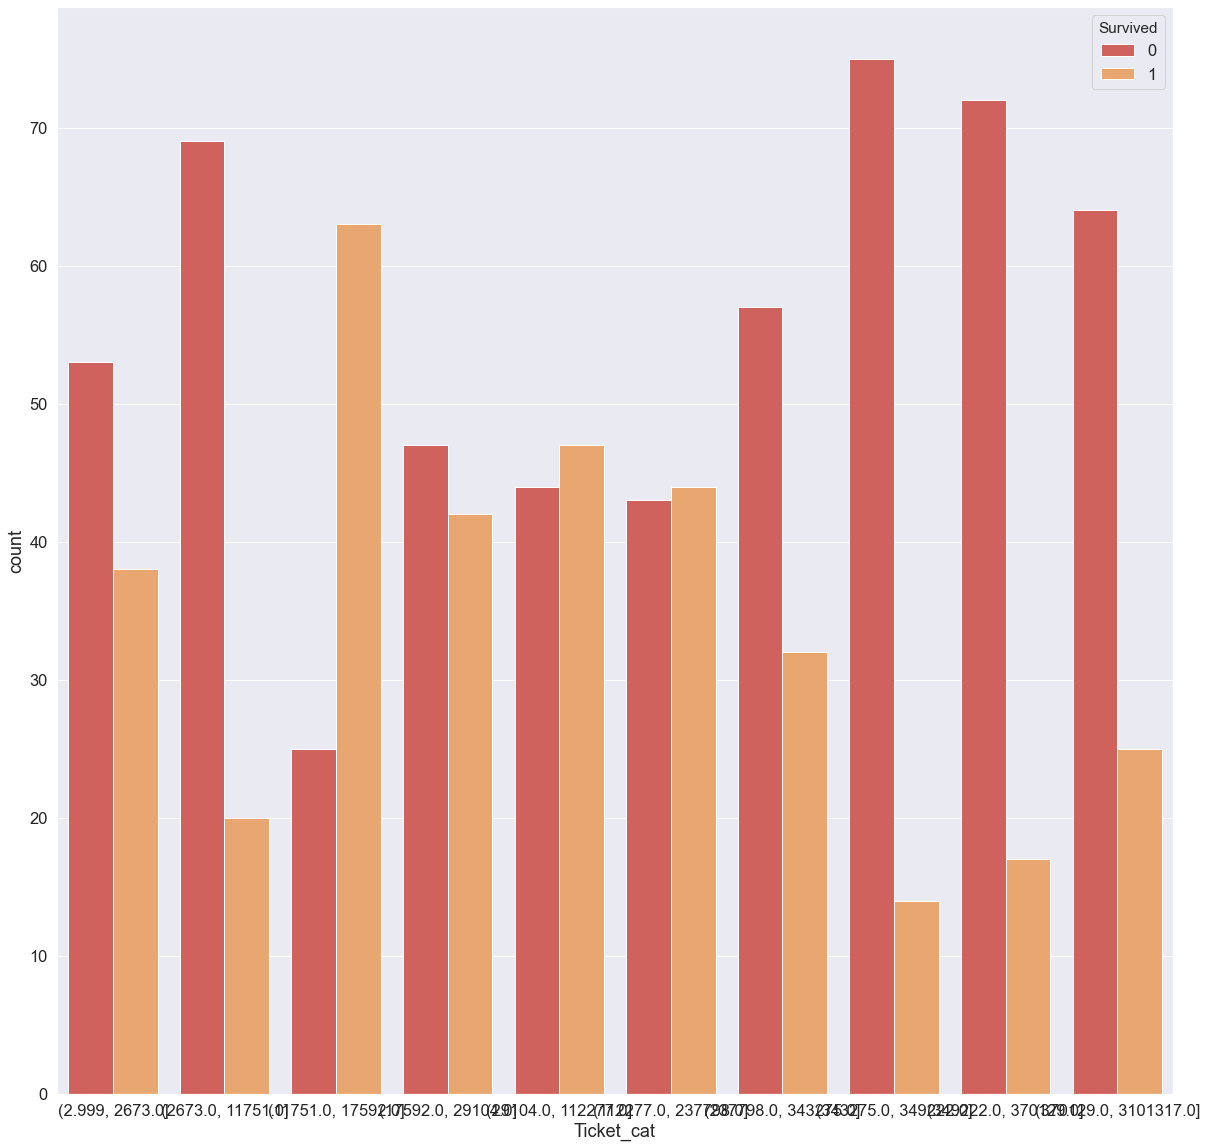

In [28]:
titanic_raw['Ticket_cat'] = pd.qcut(titanic_raw['Ticket'], 10, duplicates='drop')
plt.figure(figsize=(20, 20))
sns.countplot(x="Ticket_cat", hue="Survived", data=titanic_raw)
plt.show()

We see a normal distribution for the ticket count, which is reflected in the relationship with fare prices below.

<Figure size 1440x1440 with 0 Axes>

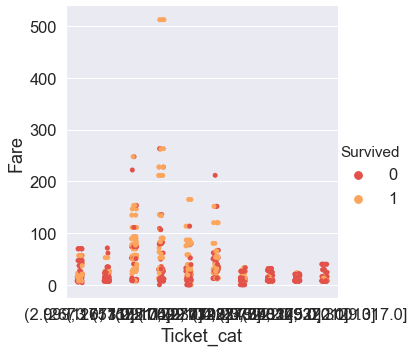

In [29]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Ticket_cat", y="Fare", hue = "Survived", data=titanic_raw)
plt.show()

### Attribute: Name, Parch and SibSp

The name attribute would only be useful if surnames or titles were extracted from they attribute to determine which passengers belonged to the same family, however this information is already encoded within other attributes, so the attribute can be dropped.

Below, we make it so the `Family Size` attribute equals 1 to signify a passenger travelling alone.

In [30]:
titanic_raw['Family Size'] = titanic_raw['SibSp'] + titanic_raw['Parch'] + 1

In [31]:
titanic_raw.drop('Name', axis=1, inplace=True)

### Attribute: Embarked

In [32]:
titanic_raw[titanic_raw['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Age_cat,Ticket_cat,Family Size
PassengerId,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,80.0,B,NaN,"(77.958, 512.329]","(32.5, 38.0]","(112277.0, 237798.0]",1
830,1,1,female,62.0,0,0,113572,80.0,B,NaN,"(77.958, 512.329]","(47.0, 80.0]","(112277.0, 237798.0]",1


These two female passengers have the same ticket number which means the tickets were likely bought together - they know each other and therefore can possibly be grouped. Looking at the charts above, upper-class passengers situated on Deck B that paid $80 for their fare must have boarded the ship from Southampton.

In [33]:
titanic_raw["Embarked"].replace(to_replace=np.nan, value='S', inplace=True)
titanic_raw[(titanic_raw['Ticket'] == 113572)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Age_cat,Ticket_cat,Family Size
PassengerId,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,80.0,B,S,"(77.958, 512.329]","(32.5, 38.0]","(112277.0, 237798.0]",1
830,1,1,female,62.0,0,0,113572,80.0,B,S,"(77.958, 512.329]","(47.0, 80.0]","(112277.0, 237798.0]",1


### Correlation

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotli

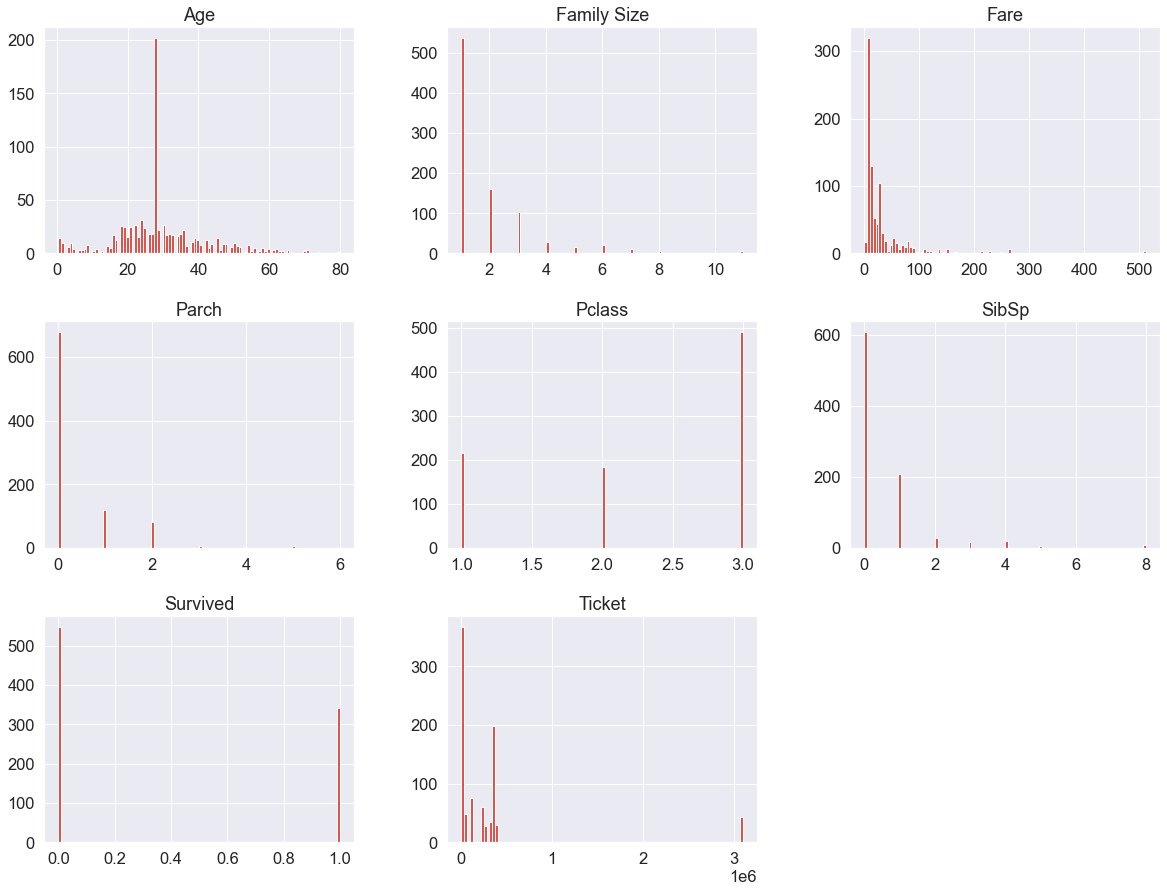

In [34]:
titanic_raw.hist(bins=100, figsize=(20,15))
plt.show()

In [35]:
titanic_raw.dtypes

Survived          int64
Pclass            int64
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket            int32
Fare            float64
Cabin            object
Embarked         object
Fare_cat       category
Age_cat        category
Ticket_cat     category
Family Size       int64
dtype: object

`Age` seems to be well distributed with few outliers, therefore a replacement with the _mean_ value for the missing values should suffice.

In [36]:
corr_matrix = titanic_raw.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
Family Size    0.016639
SibSp         -0.035322
Age           -0.064910
Ticket        -0.095844
Pclass        -0.338481
Name: Survived, dtype: float64

All these 'numerical' attributes seem to be weakly correlated with the survival rate except for `Fare`; the `Pclass` however seems to be somewhat strongly negatively correlated, in that the lower a passenger's class, the higher their chances of survival.

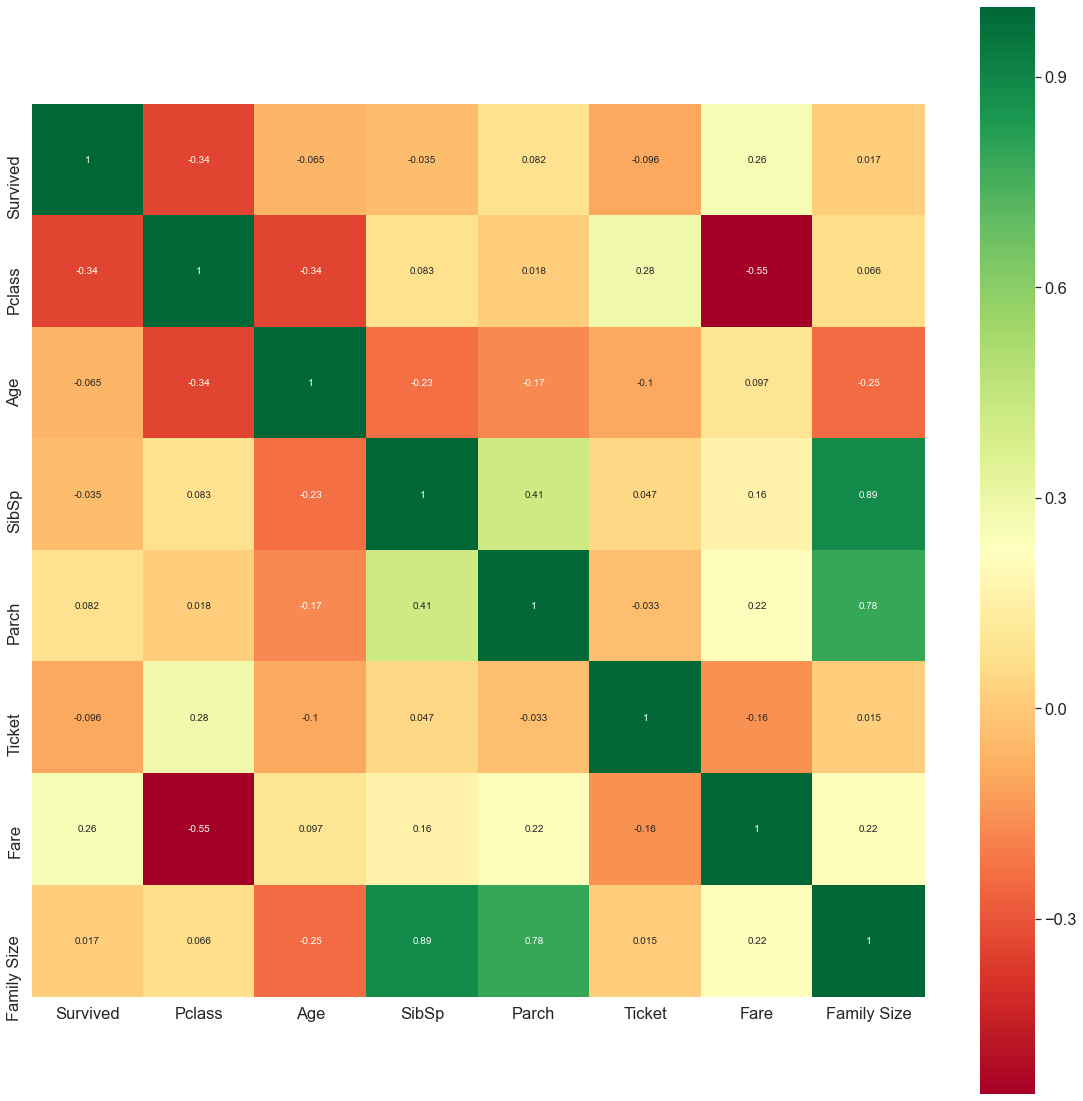

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(data=corr_matrix, square=True, annot=True, cbar=True, cmap='RdYlGn')
plt.show()

And so we have that `Fare` and `Parch` in particular are very weakly correlated with the survival rate. Naturally, we see the inverse correlation between `Pclass` and `Fare` as those with the higher class (lower value for `Pclass`) would pay higher prices for the fare. We also see that the number of siblings `SibSp` and `Parch` are positively related.

<Figure size 1440x1440 with 0 Axes>

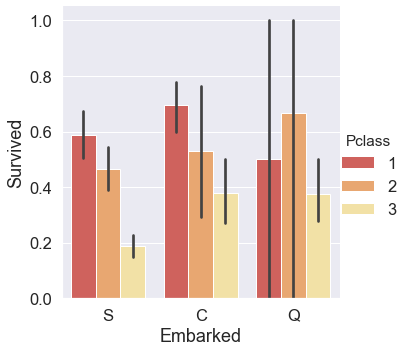

In [38]:
plt.figure(figsize=(20, 20))
sns.catplot(x="Embarked", y="Survived", hue = "Pclass", kind="bar", data=titanic_raw)
plt.show()

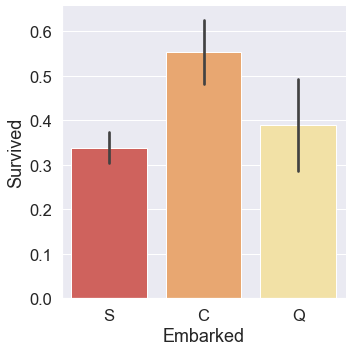

In [39]:
sns.catplot(x="Embarked", y="Survived", kind="bar", data=titanic_raw)

Another conclusion we can draw is that the fewest people survived out of those that boarded from Southampton. We will now see the significance of `Family` size and survival:

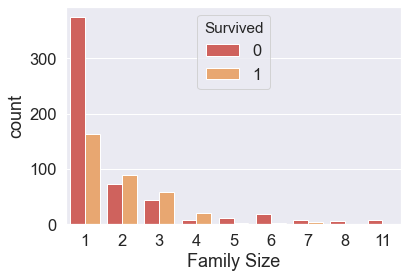

In [40]:
sns.countplot(x="Family Size", hue="Survived", data=titanic_raw)

We shall now transform our features through scaling, accomodating for the missing values and encoding the catergorical attributes. We will then move on to implementing our model training algorithms. Following this, we shall explore further feature extraction and engineering to see if it results in improvements in our model evaluations.

## Feature Transformation

#### titanic_raw.columns

In [41]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
titanic_raw['Family Size'] = titanic_raw['Family Size'].map(family_map)

In [42]:
deck_map = {'A' : 'ABC', 'B' : 'ABC', 'C' : 'ABC', 'D' : 'DE',
            'E' : 'DE', 'F' : 'FG', 'G' : 'FG', 'n' : 'Unknown'}
titanic_raw['Deck'] = titanic_raw['Cabin'].map(deck_map)

In [43]:
titanic_raw.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Age_cat,Ticket_cat,Family Size,Deck
PassengerId,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,21171,7.2500,n,S,"(-0.001, 7.55]","(20.0, 24.0]","(17592.0, 29104.0]",Small,Unknown
2,1,1,female,38.0,1,0,17599,71.2833,C,C,"(39.688, 77.958]","(32.5, 38.0]","(17592.0, 29104.0]",Small,ABC
3,1,3,female,26.0,0,0,3101282,7.9250,n,S,"(7.854, 8.05]","(24.0, 28.0]","(370129.0, 3101317.0]",Alone,Unknown
4,1,1,female,35.0,1,0,113803,53.1000,C,S,"(39.688, 77.958]","(32.5, 38.0]","(112277.0, 237798.0]",Small,ABC
5,0,3,male,35.0,0,0,373450,8.0500,n,S,"(7.854, 8.05]","(32.5, 38.0]","(370129.0, 3101317.0]",Alone,Unknown


We will not drop `SibSp` and `Parch` as both these features seem to have a higher correlation with `Survived` than `Family Size` alone. 

In [44]:
titanic_raw.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Fare_cat       0
Age_cat        0
Ticket_cat     0
Family Size    0
Deck           0
dtype: int64

In [45]:
titanic_raw.drop(["Cabin", "Age_cat", "Ticket_cat"], axis=1, inplace=True)

In [46]:
titanic = titanic_raw.drop("Survived", axis=1)
titanic_label = titanic_raw["Survived"].copy()

In [47]:
nums = titanic.select_dtypes(np.number).columns.to_list()
cats = titanic.select_dtypes('object').columns.to_list()

In [48]:
nums, cats

(['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare'],
 ['Sex', 'Embarked', 'Family Size', 'Deck'])

We shall scale our numerical data using `StandardScaler` which is less sensitive to outliers and encode the rest of the categorical datatypes using `OneHotEncoder`.

In [49]:
preprocessing = ColumnTransformer([
    ('num', StandardScaler(), nums),
    ("cat", OneHotEncoder(), cats)
])

In [50]:
pipe = preprocessing.fit_transform(titanic)

In [51]:
cat_cols = preprocessing.transformers_[1][1].get_feature_names(input_features=cats).tolist()

In [52]:
cols = nums + cat_cols  
len(cols)

19

In [53]:
titanic_prep = pd.DataFrame(data = pipe, columns = cols )

## Training Models

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.legend()
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.grid() 

In [55]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(model, x, y):
    res = [rmse(model.predict(x), y),
                model.score(x, y)]
    if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
    print(res)

### Random Forest

In [56]:
x_train = titanic_prep.copy()
y_train = titanic_label.copy()

In [57]:
forest_clf = RandomForestClassifier(random_state=42)
%time forest_clf.fit(x_train, y_train)
print_score(forest_clf, x_train, y_train)


Wall time: 18 ms
[0.138129235668458, 0.9809203142536476]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [58]:
cross_val_score(forest_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.75420875, 0.82154882, 0.81481481])

In [59]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train, cv=3)

forest_matrix = confusion_matrix(y_train, y_train_pred_forest)
forest_matrix

array([[475,  74],
       [107, 235]], dtype=int64)

In [60]:
rec_forest = recall_score(y_train, y_train_pred_forest)
prec_forest = precision_score(y_train, y_train_pred_forest)

prec_forest, rec_forest

(0.7605177993527508, 0.6871345029239766)

In [61]:
y_scores_forest = cross_val_predict(forest_clf, x_train, y_train, cv=3, method="predict_proba")

y_scores_forest = y_scores_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

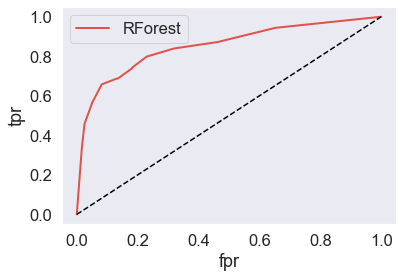

In [62]:
#plt.plot(fpr_tree, tpr_tree, "g:", label="DTree")
#plt.plot(fpr_knn, tpr_knn, "r:", label="KNN")
#plt.plot(fpr_sgd, tpr_sgd, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="RForest")
#plt.legend(loc="lower right")
plt.show()

In [63]:
roc_auc_score(y_train, y_scores_forest)

0.8505602956997838

## Fine-Tuning Hyperparameters

Using all our data can lead to overfitting; we have obtained the best accuracy on the training set and this accuracy may not carry over to new data, i.e the test set. A validation set helps diagnose this problem, as we require an independant dataset that was not used to create the model in the first place, which we create below while bearing in mind that we are attempting to somewhat replicate the test set.

In [64]:
param_grid = {
        'n_estimators': [30, 50, 70],
        'max_features':[8, 12, 16],
    }

In [65]:
grid_search = GridSearchCV(forest_clf, param_grid,
                           cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_

In [66]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

### Feature Importance

In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_
fi_list = sorted(zip(cols, feature_importances), reverse=True)

In [68]:
fi_list.sort(key=lambda x: x[1], reverse=True)


In [69]:
fi =  pd.DataFrame(fi_list, columns=["Features", "Feature Importance"])

In [70]:
fi

,Features,Feature Importance
0,Ticket,0.212265
1,Age,0.157874
2,Sex_male,0.147701
3,Fare,0.144727
4,Sex_female,0.125916
5,Pclass,0.060570
6,SibSp,0.024401
7,Deck_Unknown,0.023122
8,Parch,0.021889
9,Family Size_Small,0.019301


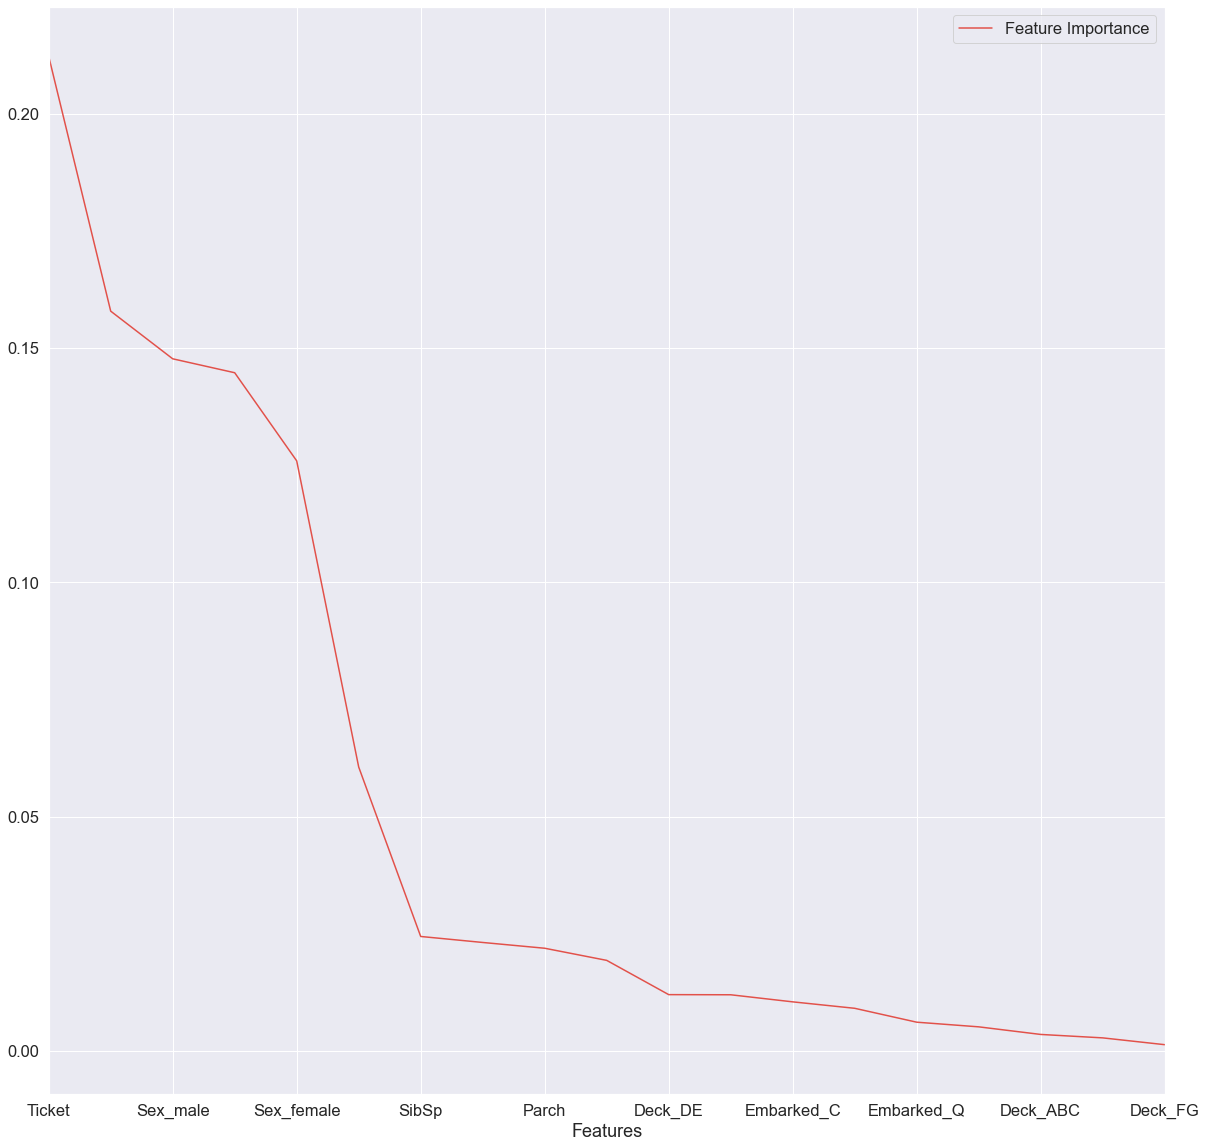

In [71]:
fi.plot('Features', 'Feature Importance', figsize=(20,20))
plt.show()

In [72]:
def plot_fi(fi): 
    
    return fi.plot('Features', 'Feature Importance', 'barh', 
                   figsize=(12,7))

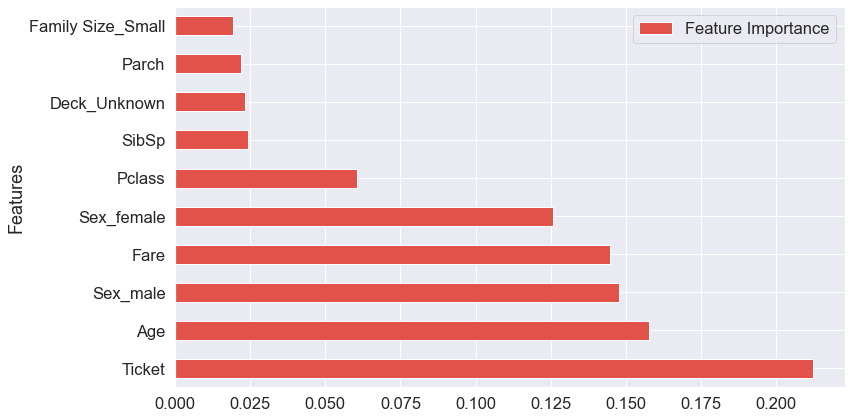

In [73]:
plot_fi(fi[:10]);

Let us try removing features with importance < 0.02:

In [74]:
to_keep = fi[fi['Feature Importance'] > 0.005]

In [75]:
to_keep_cols = to_keep['Features'].tolist()

In [76]:
to_keep_cols

['Ticket',
 'Age',
 'Sex_male',
 'Fare',
 'Sex_female',
 'Pclass',
 'SibSp',
 'Deck_Unknown',
 'Parch',
 'Family Size_Small',
 'Deck_DE',
 'Embarked_S',
 'Embarked_C',
 'Family Size_Medium',
 'Embarked_Q',
 'Family Size_Alone']

In [77]:
x_train_keep = x_train[to_keep_cols].copy()

In [78]:
forest_clf_keep = RandomForestClassifier(random_state=42, n_estimators=30, max_features=8, oob_score=True)
%time forest_clf_keep.fit(x_train_keep, y_train)
print_score(forest_clf_keep, x_train_keep, y_train)

Wall time: 56.8 ms
[0.058025885318565944, 0.9966329966329966, 0.8282828282828283]


In [79]:
cross_val_score(forest_clf_keep, x_train_keep, y_train, cv=3, scoring="accuracy")

array([0.78451178, 0.85185185, 0.83501684])

In [80]:
feature_importances_keep = grid_search.best_estimator_.feature_importances_
fi_list_keep = sorted(zip(cols, feature_importances), reverse=True)
fi_list_keep.sort(key=lambda x: x[1], reverse=True)
fi_keep =  pd.DataFrame(fi_list, columns=["Features", "Feature Importance"])

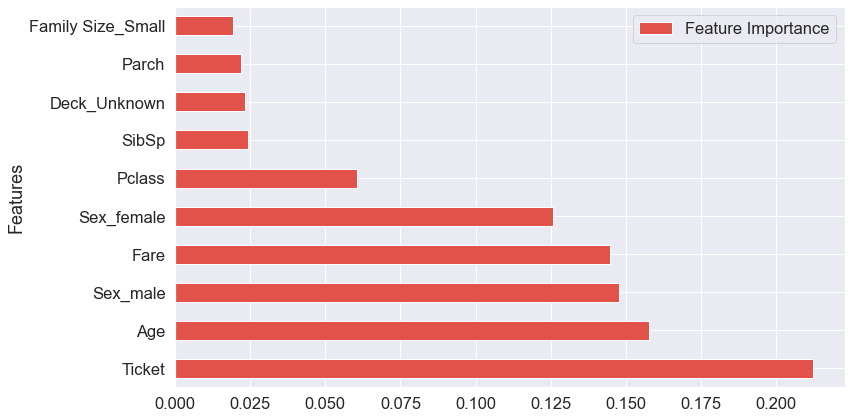

In [81]:
plot_fi(fi_keep[:10])

Removing seemingly redundant features achieved a better score and a better OOB-score. 

In [82]:
y_train_pred_forest_keep = cross_val_predict(forest_clf_keep, x_train_keep, y_train, cv=3)

In [83]:
rec_forest_keep = recall_score(y_train, y_train_pred_forest_keep)
prec_forest_keep = precision_score(y_train, y_train_pred_forest_keep)

prec_forest_keep, rec_forest_keep

(0.8032786885245902, 0.716374269005848)

In [84]:
y_scores_forest_keep = cross_val_predict(forest_clf_keep, x_train_keep, y_train, cv=3, method="predict_proba")

y_scores_forest_keep = y_scores_forest_keep[:, 1]

fpr_forest_keep, tpr_forest_keep, thresholds_forest_keep = roc_curve(y_train, y_scores_forest_keep)

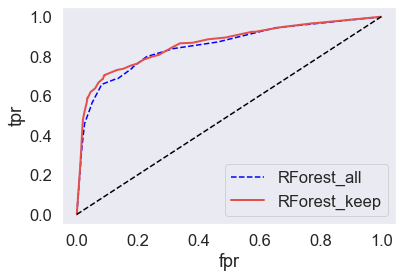

In [85]:
plt.plot(fpr_forest, tpr_forest, '--b', label='RForest_all')
plot_roc_curve(fpr_forest_keep, tpr_forest_keep, label="RForest_keep")
plt.show()

In [86]:
roc_auc_score(y_train, y_scores_forest_keep)

0.8625225023700721

## Removing redundant features

In [87]:
from scipy.cluster import hierarchy as hc


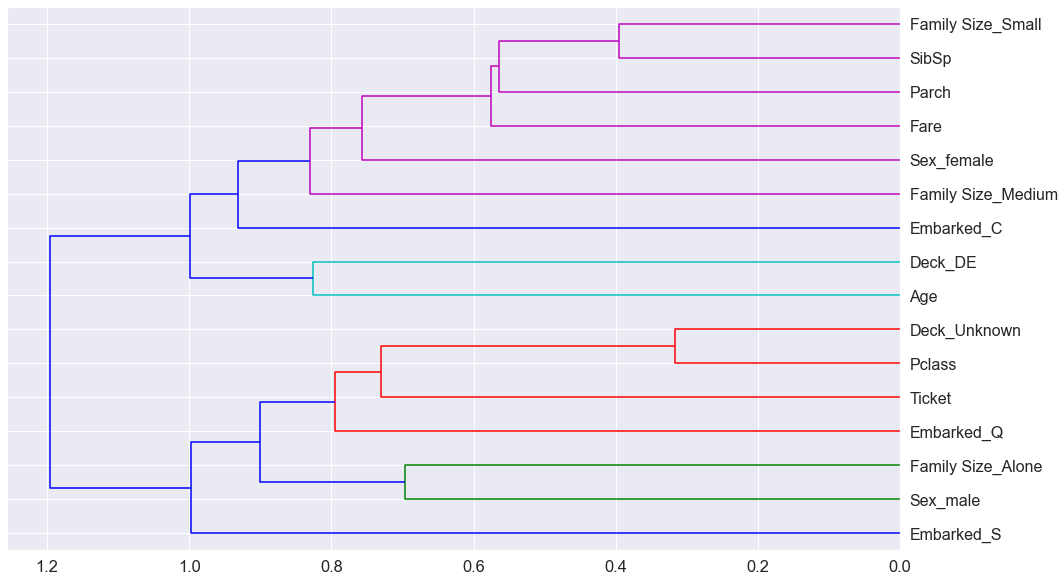

In [88]:
corr = np.round(scipy.stats.spearmanr(x_train_keep).correlation, 6) # 6 d.p
corr_condensed = hc.distance.squareform(1-corr) #step 1
z = hc.linkage(corr_condensed, method='average') #step 2
fig = plt.figure(figsize=(16,10))
#step 3:
dendrogram = hc.dendrogram(z, labels=x_train_keep.columns,orientation='left', leaf_font_size=16)
plt.show()

This dendogram shows us that `Family Size_Small` and `Parch` seem to be somewhat correlated, along with `Fare`.

In [89]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=30, max_features=8, oob_score=True)
    m.fit(x_train_keep, y_train)
    return m.oob_score_

In [90]:
for c in ('Parch', 'Fare', 'Family Size_Small'):
    print(c, get_oob(x_train_keep.drop(c, axis=1)))

Parch 0.819304152637486
Fare 0.8327721661054994
Family Size_Small 0.8260381593714927


In [91]:
for c in ('Fare', 'Family Size_Small'):
    print(c, get_oob(x_train_keep.drop(c, axis=1)))

Fare 0.8237934904601572
Family Size_Small 0.8170594837261503


In [92]:
to_drop2 = ['Family Size_Small']
x_train_keep.drop(to_drop2, axis=1, inplace=True)

In [93]:
forest_clf_keep2 = RandomForestClassifier(random_state=42, n_estimators=30, max_features=8, oob_score=True)
%time forest_clf_keep2.fit(x_train_keep, y_train)
print_score(forest_clf_keep2, x_train_keep, y_train)

Wall time: 58.8 ms
[0.07491109582924912, 0.9943883277216611, 0.8305274971941639]


Our score has now improved by dropping a redundant feature.

## Evaluation on Test Set

### Cleaning the Test Set

In [94]:
test_raw = pd.read_csv("C:/Users/user/Documents/Q/datasets/titanic/test.csv", index_col="PassengerId", encoding="latin1")

In [95]:
test_raw.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

We replace the missing values under the `Age` attribute with the median age that we calculated for the training set.

In [96]:
test_raw["Age"].fillna(med, inplace=True)

In [97]:
test_raw.isnull().sum()

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [98]:
test_raw[test_raw["Fare"].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


According to the correlation matrix, `Fare` has strong correlation to `Pclass`, therefore replacing the missing value with the median value for a lower-class individual:

In [99]:
titanic_raw.groupby('Pclass').Fare.median()

Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64

In [100]:
med_fare = titanic_raw.groupby('Pclass').Fare.median()[3]
test_raw["Fare"].fillna(med_fare, inplace=True)

In [101]:
test_raw.isnull().sum()

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       327
Embarked      0
dtype: int64

In [102]:
test_raw["Cabin"].fillna('n', inplace=True)

In [103]:
cabins = []
cab_raw = test_raw["Cabin"]
for cabin in cab_raw:
    cabin = str(cabin)
    cab = cabin[0]
    cabins.append(cab)
    
test_raw['Cabin'] = cabins   
test_raw['Cabin'].value_counts()

n    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

In [104]:
test_raw['Family Size'] = test_raw['SibSp'] + test_raw['Parch'] + 1

In [105]:
family_map2 = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
test_raw['Family Size'] = test_raw['Family Size'].map(family_map2)

In [106]:
deck_map2 = {'A' : 'ABC', 'B' : 'ABC', 'C' : 'ABC', 'D' : 'DE',
            'E' : 'DE', 'F' : 'FG', 'G' : 'FG', 'n' : 'Unknown'}
test_raw['Deck'] = test_raw['Cabin'].map(deck_map2)

In [107]:
test_raw.drop(['Name', 'Cabin'], axis=1, inplace=True)

In [108]:
test_raw.Ticket.value_counts()

PC 17608              5
CA. 2343              4
113503                4
16966                 3
C.A. 31029            3
                     ..
19924                 1
A.5. 3236             1
350408                1
SOTON/O.Q. 3101262    1
248726                1
Name: Ticket, Length: 363, dtype: int64

In [109]:
numbers2 = []
tickets2 = test_raw["Ticket"]

for tick in tickets2:
    tick = str(tick)
    nums = tick.split(" ")
    if len(nums) == 3:
        numbers2.append(nums[2])
    elif len(nums) == 2:
        numbers2.append(nums[1])
    else:
        numbers2.append(nums[0])

test_raw["Ticket"] = numbers2  

In [110]:
med_calc2 = []
for row in test_raw["Ticket"]:
    if row.isdigit() == True:
        med_calc2.append(row)
med_calc2 = [int(i) for i in med_calc2]   
med_tick2 = np.median(med_calc2)
med_tick2 = round(med_tick2)

test_raw["Ticket"].replace(to_replace="LINE", value=int(med_tick2), inplace=True)
test_raw["Ticket"] = test_raw["Ticket"].astype(str).astype(int)

In [111]:
test_raw["Ticket"].unique

<bound method Series.unique of PassengerId
892      330911
893      363272
894      240276
895      315154
896     3101298
         ...   
1305       3236
1306      17758
1307    3101262
1308     359309
1309       2668
Name: Ticket, Length: 418, dtype: int32>

Below is a list of the attributes we dropped from our training set:

- `Name`
- `Cabin`
- `Family Size_Small`

In [112]:
test = test_raw.copy()

In [113]:
cats2 = test.select_dtypes('object').columns.to_list()
nums2 = test.select_dtypes(np.number).columns.to_list()

In [114]:
cats2, nums2

(['Sex', 'Embarked', 'Family Size', 'Deck'],
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare'])

In [115]:
pipeline2 = ColumnTransformer([
    ("num2", StandardScaler(), nums2),
    ("cat2", OneHotEncoder(), cats2),
])

In [116]:
pipe2 = pipeline2.fit_transform(test)

In [117]:
cat_cols2 = pipeline2.transformers_[1][1].get_feature_names(input_features=cats2).tolist()

In [118]:
cols2 = nums2 + cat_cols2

In [119]:
test_prep = pd.DataFrame(data = pipe2, columns = cols2 )

In [120]:
test_prep.shape

(418, 19)

In [121]:
to_keep_cols.remove('Family Size_Small')

In [122]:
test_prep = test_prep[to_keep_cols]

In [123]:
test_prep.drop(['SibSp', 'Deck_Unknown'], axis=1, inplace=True)

### Testing Performance

In [124]:
y_preds = forest_clf_keep2.predict(test_prep)

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 13 

In [ ]:
test_prep.reset_index(inplace=True)

In [ ]:
test.reset_index(inplace=True)

In [ ]:
test

In [ ]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_preds
})

submission.to_csv('titanic_sub.csv', index=False)